/usr/local/home/zlnh4/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


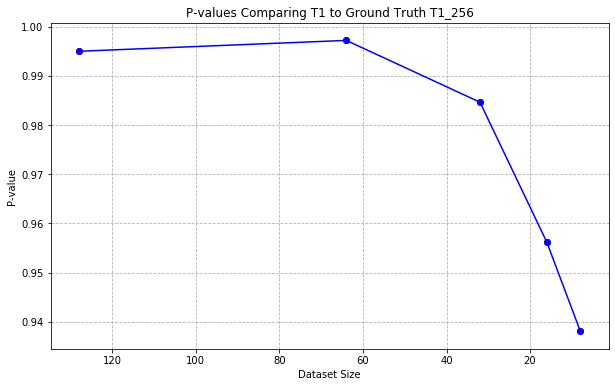

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Define the mono-exponential function
def bi_exp(t, S1, T1, S2, T1_2, S3, T1_3):
    return S1 * np.exp(-t / T1) + S2 * np.exp(-t / T1_2) + S3 * np.exp(-t / T1_3)


RAW_DATA = pd.read_csv("decay_data/tri_decay.csv")

Tau_256 = RAW_DATA["TAU"]
Intensity_256 = RAW_DATA["INTENSITY"]

# Assuming Tau_256 and Intensity_256 are your original datasets
Tau_256 = Tau = Tau_256
Intensity = Intensity_256


initial_values = [Intensity[0], 0.5, Intensity[0], 0.05, Intensity[0], 0.005]


# Fit the mono-exponential function to the 256-point dataset to obtain the ground truth parameters
params_gt, _ = curve_fit(bi_exp, Tau, Intensity, p0 = initial_values)


gt_curve = bi_exp(Tau, *params_gt)

# Initial values for the curve fitting
p_values = []
sizes = [len(Tau)]

curves = [params_gt]

# Loop to halve the dataset and fit the reduced datasets
while len(Tau) > 8:
    # Halve the dataset
    Tau = Tau[::2]
    Intensity = Intensity[::2]
    # Fit the mono-exponential function to the reduced dataset
    params, _ = curve_fit(bi_exp, Tau, Intensity, p0=initial_values)
    curves.append(params)
    # Perform T-test comparing T1 to the ground truth T1_gt
    t_stat, p_value = ttest_ind(gt_curve, bi_exp(Tau_256, *params))
    p_values.append(p_value)
    sizes.append(len(Tau))

    
# Plotting the p-values
plt.figure(figsize=(10, 6))
plt.plot(sizes[1:], p_values, marker='o', linestyle='-', color='b')  # Skip the first size since it's the ground truth
plt.scatter(sizes[1:], p_values, color='r')  # Highlight each point

plt.xlabel('Dataset Size')
plt.ylabel('P-value')
plt.title('P-values Comparing T1 to Ground Truth T1_256')
plt.grid(True, which="both", ls="--")
plt.gca().invert_xaxis()  # Invert x-axis to show decreasing dataset size from left to right

plt.show()

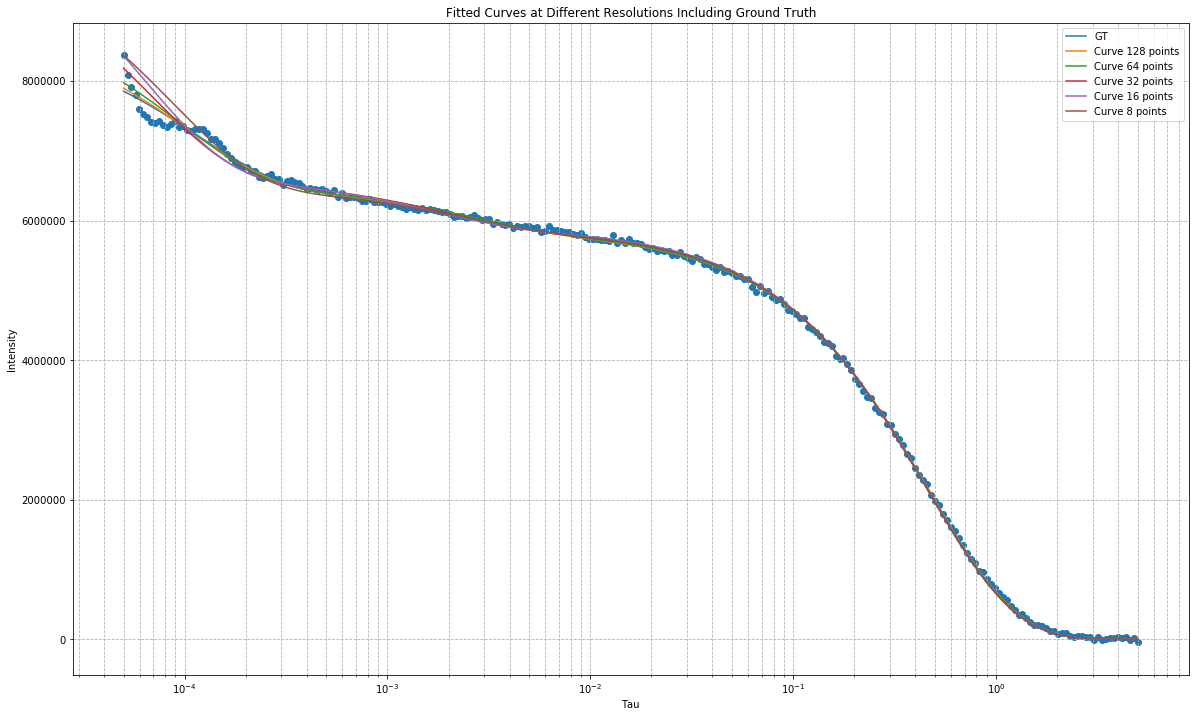

In [7]:
plt.figure(figsize=(20, 12))


for i, params in enumerate(curves):
    # Generate curve values using the stored parameters
    curve_values = bi_exp(Tau_256, *params)
    label = 'GT' if i == 0 else f'Curve {len(Tau_256)//(2**i)} points'
    plt.plot(Tau_256, curve_values, label=label)

plt.scatter(Tau_256, Intensity_256)

plt.xlabel('Tau')
plt.ylabel('Intensity')
plt.title('Fitted Curves at Different Resolutions Including Ground Truth')
plt.legend()
plt.xscale('log')  # Optional: Log scale for the x-axis
plt.grid(True, which="both", ls="--")
plt.show()

[(5e-05, 7853228.052381358),
 (0.000212, 7824312.194466276),
 (0.000899, 7794758.121896834),
 (0.00381, 7763439.160768811),
 (0.0162, 7732829.727775272),
 (0.0686, 7700640.427234789),
 (0.2909, 7668127.658786294),
 (1.2335, 7635355.62731687)]